## Compare weights of Earthquake Transformer




- Weights for Seisbench (original.pt) are downloaded from https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/models/eqtransformer/
- Weights from original Earthquake Trnasformer are downloaded from https://github.com/smousavi05/EQTransformer/tree/master/ModelsAndSampleData


---
 ##### Yiyu Ni (niyiyu@uw.edu)
 ##### Earth and Space Sciences
 ##### University of Washington

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt

# Loading weights from Seisbench and EqTransformer

- Weights for Seisbench (original.pt) are downloaded from [here](https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/models/eqtransformer/)
- Weights from original Earthquake Trnasformer are downloaded from [here](https://github.com/smousavi05/EQTransformer/tree/master/ModelsAndSampleData)

In [2]:
para_sbm = torch.load("./original.pt")
para_eqt = h5py.File("./EqT_model.h5", mode = "r")

# Comparing two weight files
Since two weights are outputed by different packages, and also vary in their name, it is hard to compare all weights directly. But we can pick one of them and check manually. To compare the parameters, one weight matrix is subtracted from another, and a zero matrix is expected as the result, which indicates that there is no difference between two matrices.

## All four Transformer matches

In [3]:
for att_eqt, att_sbm in zip(['attentionD', 'attentionD0', 'attentionP', 'attentionS'], 
                            ['transformer_d.attention', 'transformer_d0.attention', 'pick_attentions.0', 'pick_attentions.1']):
    for i in ['Wt', 'Wx', 'bh', 'ba']:
        attention_eqt = para_eqt['model_weights'][att_eqt][att_eqt][att_eqt + '_Add_%s:0' % i][:]
        attention_sbm = np.array(para_sbm[att_sbm + '.' + i][:])
        print((attention_eqt - attention_sbm).sum())

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [4]:
picker_eqt = para_eqt['model_weights']['picker_P']['picker_P']['kernel:0'][:]
picker_sbm = np.array(para_sbm['pick_convs.0.weight'].permute([2, 1, 0])[:])
print((picker_eqt - picker_sbm).sum())

0.0


## For the convolution layers

In [5]:
for i in range(7):
    bias_eqt = para_eqt['model_weights']['conv1d_%d' % (i+1)]['conv1d_%d' % (i+1)]['bias:0']
    bias_sbm = np.array(para_sbm['encoder.convs.%d.bias' % i])
    weight_eqt = para_eqt['model_weights']['conv1d_%d' % (i+1)]['conv1d_%d' % (i+1)]['kernel:0']
    weight_sbm = np.array(para_sbm['encoder.convs.%d.weight' % i].permute([2, 1, 0]))
    print("\tBias\tWeights\nEqT:\t%s\t%s\nsbm:\t%s\t%s" %
          (bias_eqt.shape, weight_eqt.shape, bias_sbm.shape, weight_sbm.shape))
    print("Bias abs diff:\t\t%.3f\nweight abs diff:\t%.3f\n" % 
          (sum(bias_sbm - bias_eqt).sum(), abs(weight_sbm - weight_eqt).sum()))

	Bias	Weights
EqT:	(8,)	(11, 3, 8)
sbm:	(8,)	(11, 3, 8)
Bias abs diff:		0.000
weight abs diff:	35.329

	Bias	Weights
EqT:	(16,)	(9, 8, 16)
sbm:	(16,)	(9, 8, 16)
Bias abs diff:		0.000
weight abs diff:	0.000

	Bias	Weights
EqT:	(16,)	(7, 16, 16)
sbm:	(16,)	(7, 16, 16)
Bias abs diff:		0.000
weight abs diff:	0.000

	Bias	Weights
EqT:	(32,)	(7, 16, 32)
sbm:	(32,)	(7, 16, 32)
Bias abs diff:		0.000
weight abs diff:	0.000

	Bias	Weights
EqT:	(32,)	(5, 32, 32)
sbm:	(32,)	(5, 32, 32)
Bias abs diff:		0.000
weight abs diff:	0.000

	Bias	Weights
EqT:	(64,)	(5, 32, 64)
sbm:	(64,)	(5, 32, 64)
Bias abs diff:		0.000
weight abs diff:	0.000

	Bias	Weights
EqT:	(64,)	(3, 64, 64)
sbm:	(64,)	(3, 64, 64)
Bias abs diff:		0.000
weight abs diff:	0.000



As expected, the shape of bias and weights matches. The values of bias match perfectly. But there is mismatch in the input layer's weight.

## So, take a look at what's differen with the input layer's weight
The intput layer is labeled as **"Conv 1D, 8 kr 11, MaxPooling/2"** in the Figure 1 of Mousavi's paper. This is a 1D convolution layer that has 8 kernels, 3 input channel, and 11 kernel size.

In [6]:
bias_eqt = para_eqt['model_weights']['conv1d_1']['conv1d_1']['bias:0']
bias_sbm = np.array(para_sbm['encoder.convs.0.bias'])
weight_eqt = para_eqt['model_weights']['conv1d_1']['conv1d_1']['kernel:0'][:, :, :]
weight_sbm = np.array(para_sbm['encoder.convs.0.weight'].permute([2, 1, 0]))
print("\tBias\tWeights\nEqT:\t%s\t%s\nsbm:\t%s\t%s" %
      (bias_eqt.shape, weight_eqt.shape, bias_sbm.shape, weight_sbm.shape))

	Bias	Weights
EqT:	(8,)	(11, 3, 8)
sbm:	(8,)	(11, 3, 8)


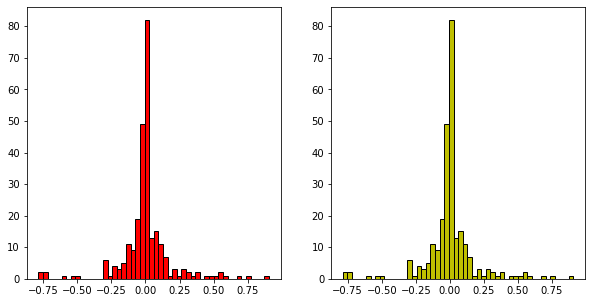

In [7]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
_ = plt.hist(weight_sbm.flatten(), 50, color = 'r', edgecolor = 'k')
plt.subplot(1, 2, 2)
_ = plt.hist(weight_eqt.flatten(), 50, color = 'y', edgecolor = 'k')

Histogram shows that weights follow exactly the same distribution, which indicate that the values are the same, but their orders are not. Results show that weights does not match partially. 

## The first and third channels are swapped.

In [8]:
weight_sbm - weight_eqt

array([[[-0.0638267 ,  0.07888036,  0.00114959, -0.10464834,
          0.13037263,  0.3779272 ,  0.22011526, -0.24125506],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.0638267 , -0.07888036, -0.00114959,  0.10464834,
         -0.13037263, -0.3779272 , -0.22011526,  0.24125506]],

       [[-0.0751636 , -0.00753759, -0.00353981,  0.20217833,
          0.11652699,  0.29299304,  0.13031586, -0.14651714],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.0751636 ,  0.00753759,  0.00353981, -0.20217833,
         -0.11652699, -0.29299304, -0.13031586,  0.14651714]],

       [[-0.10143881, -0.02302781, -0.00955793, -0.1896888 ,
          0.16863841,  0.4960329 , -0.6954344 , -0.2699585 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.

## Actually, this matches what seisbench expects.
In seisbench's configure file, the channel is in the order of "ZNE" by default. See configure [here](https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/models/eqtransformer/original.json?action=show). This does not matches original implementation of Earthquake Transformer, which is in the order of "ENZ" and is shown [here](https://github.com/smousavi05/EQTransformer/blob/master/EQTransformer/utils/hdf5_maker.py#L212-L220). It is reasonable to swap these weights of input layer.